# Annual Cycle Climatology Test: CDAT vs Xarray

[Jiwoo Lee](https://github.com/lee1043/) (LLNL), March 2021

In this document, annual cycle climatology fields calculated using [CDAT](https://cdat.llnl.gov/) and [Xarray](xarray.pydata.org/) are compared for checking consistency.

NOTE: CDAT's annual cycle climatology obtained from `cdutil.ANNUALCYCLE.climatology` seems to be not weighted with leap year associated weighting.

Useful resources:
- [Xarray instrcution from NCI data training](https://nci-data-training.readthedocs.io/en/latest/_notebook/climate/1_01_Xarray_access_CMIP5.html)
- [Xarray example: Calculating Seasonal Averages from Time Series of Monthly Means](http://xarray.pydata.org/en/stable/examples/monthly-means.html)

Testing Environment:
```
conda create -y -n cdat_v8.2.1 -c conda-forge -c cdat/label/v8.2.1 cdat "libnetcdf=*=mpi_openmpi_*" "mesalib=17.3.9" "python=3.7"
conda activate cdat_v8.2.1
conda install -c conda-forge xarray 
conda install -c conda-forge netcdf4 
```

## Example input data

In [1]:
input_file = "demo_data/CMIP5_demo_data/ts_Amon_ACCESS1-0_historical_r1i1p1_185001-200512.nc"

## Import libraries

In [2]:
import cdms2
import cdutil

In [3]:
import xarray as xr
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## CDAT

### Load data

In [5]:
%%time

fc = cdms2.open(input_file)
dc = fc('ts', time=slice(0,48)) - 273.15  # Take first 4 years (0-48) and unit adjust (-273.15, K to C)

CPU times: user 25.2 ms, sys: 15.2 ms, total: 40.3 ms
Wall time: 39.1 ms


### Calculate Seasonal Climatology

In [6]:
%%time

dc_ann_clim = cdutil.ANNUALCYCLE.climatology(dc)

CPU times: user 184 ms, sys: 5.83 ms, total: 190 ms
Wall time: 189 ms


In [7]:
print(dc_ann_clim.shape)

dc_ann_clim.id = dc.id
dc_ann_clim.getTime().asComponentTime()

(12, 145, 192)


[1-1-16 12:0:0.0,
 1-2-15 0:0:0.0,
 1-3-16 12:0:0.0,
 1-4-16 0:0:0.0,
 1-5-16 12:0:0.0,
 1-6-16 0:0:0.0,
 1-7-16 12:0:0.0,
 1-8-16 12:0:0.0,
 1-9-16 0:0:0.0,
 1-10-16 12:0:0.0,
 1-11-16 0:0:0.0,
 1-12-16 12:0:0.0]

### Global area average

In [8]:
%%time

dc_ann_clim_ts = cdutil.averager(dc_ann_clim, axis='xy')
dc_ann_clim_ts.id = dc.id

CPU times: user 18.7 ms, sys: 5.87 ms, total: 24.6 ms
Wall time: 22.9 ms


### Convert data type for quick plotting

Convert array type from CDAT transient variable to Xarray data array

In [9]:
time = dc.getTime()
lat = dc.getLatitude()
lon = dc.getLongitude()

In [10]:
dc_ann_clim_xr = xr.DataArray(dc_ann_clim, 
                              coords=[list(time)[0:12], list(lat), list(lon)], 
                              dims=["time", "lat", "lon"], 
                              name=dc.id)

## Xarray

### Load data

In [11]:
%%time
fx = xr.open_dataset(input_file, decode_times=True)
dx = fx.ts[0:48] - 273.15  # Take first 4 years (0-48) and unit adjust (-273.15, K to C)

CPU times: user 271 ms, sys: 12.3 ms, total: 284 ms
Wall time: 283 ms


### Calculating Seasonal Averages from Timeseries of Monthly Means

Adapted from example at http://xarray.pydata.org/en/stable/examples/monthly-means.html

In [12]:
def annual_cycle_climatology(d, weighted=True):
    if weighted:
        # Make a DataArray with the number of days in each month, size = len(time)
        month_length = d.time.dt.days_in_month

        # Calculate the weights by grouping by 'time.month'
        weights = month_length.groupby('time.month') / month_length.groupby('time.month').sum()

        # Test that the sum of the weights for each season is 1.0
        np.testing.assert_allclose(weights.groupby('time.month').sum().values, np.ones(12))

        # Calculate the weighted average
        return (d * weights).groupby('time.month').sum(dim='time')
    else:
        # Alternative way (https://github.com/willyhagi/climate-data-science/blob/master/Python-Scripts/annual_cycle.py)
        # Does not consider weighting
        return d.groupby('time.month').mean('time')

In [13]:
def annual_cycle_climatology_manual_test(dx):
    a = dx.groupby('time.month').mean('time')[1]
    b = (dx[1] + dx[13] + dx[25] + dx[37])/4.

    d1 = dx[1].time.dt.days_in_month
    d2 = dx[13].time.dt.days_in_month
    d3 = dx[25].time.dt.days_in_month
    d4 = dx[37].time.dt.days_in_month

    w1 = d1 / (d1+d2+d3+d4)
    w2 = d2 / (d1+d2+d3+d4)
    w3 = d3 / (d1+d2+d3+d4)
    w4 = d4 / (d1+d2+d3+d4)

    return (dx[1]*w1 + dx[13]*w2 + dx[25]*w3 + dx[37]*w4)

In [14]:
%%time

# With weighting
dx_ann_clim = annual_cycle_climatology(dx)

CPU times: user 36.9 ms, sys: 9.63 ms, total: 46.5 ms
Wall time: 44.9 ms


In [15]:
%%time

# Without weighting
dx_ann_clim_no_weight = annual_cycle_climatology(dx, weighted=False)

CPU times: user 9.49 ms, sys: 4.33 ms, total: 13.8 ms
Wall time: 12 ms


In [16]:
%%time

# With weighting -- manual
dx_ann_clim_manual_weight = annual_cycle_climatology_manual_test(dx)

CPU times: user 26.4 ms, sys: 2.66 ms, total: 29.1 ms
Wall time: 27.9 ms


### Global area average

Reference: http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html

In [17]:
def area_averager(d):
    weights = np.cos(np.deg2rad(d.lat))
    weights.name = "weights"
    d_weighted = d.weighted(weights)
    d_weighted_mean = d_weighted.mean(("lon", "lat"))
    return(d_weighted_mean)

In [18]:
%%time

dx_ann_clim_ts = area_averager(dx_ann_clim)
dx_ann_clim_ts_no_weight = area_averager(dx_ann_clim_no_weight)

CPU times: user 14.4 ms, sys: 1.86 ms, total: 16.3 ms
Wall time: 15.1 ms


### Quick plot to show the results

## Check Difference between CDAT and Xarray

### Map

Text(0.5, 1.02, 'Surface Air Temperature at t=1, first Feb.')

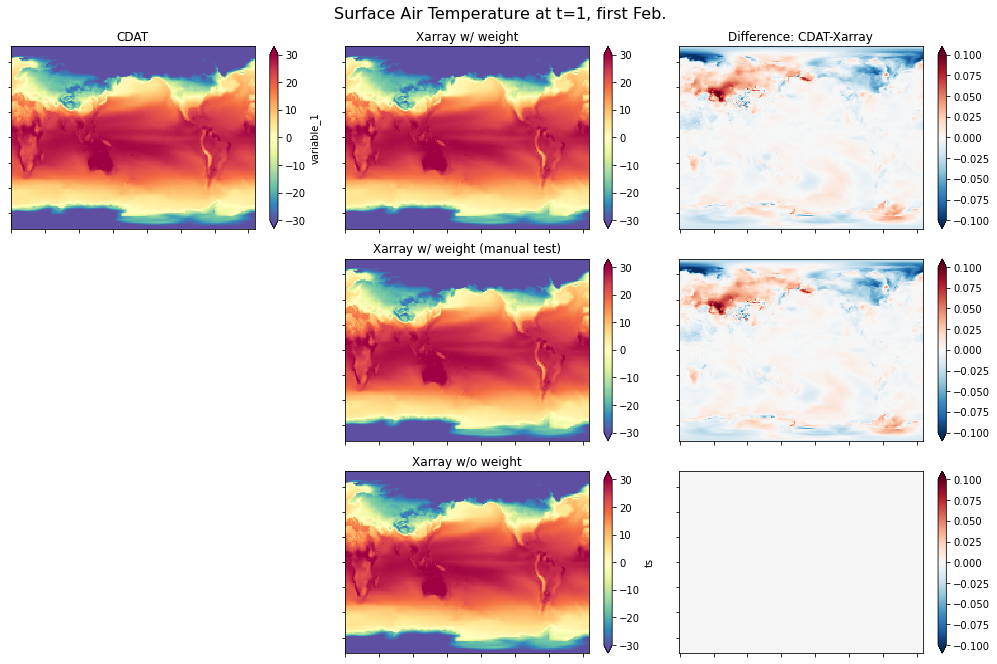

In [19]:
tstep = 1

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,9))

notnull = pd.notnull(dx_ann_clim[tstep])

for i in range(3):
       
    cmap = 'Spectral_r'
    vmin = -30
    vmax = 30

    cmap_diff = 'RdBu_r'
    vmin_diff = -0.1
    vmax_diff = 0.1
        
    # CDAT
    if i == 0:
        dc_ann_clim_xr[tstep].plot.pcolormesh(
            ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap,
            add_colorbar=True, extend='both') 
    else:
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        axes[i,0].spines['bottom'].set_color('white')
        axes[i,0].spines['top'].set_color('white')
        axes[i,0].spines['left'].set_color('white')
        axes[i,0].spines['right'].set_color('white')
    
    if i == 0:
        dx_tmp = dx_ann_clim[tstep]
    elif i == 1:
        dx_tmp = dx_ann_clim_manual_weight
    elif i == 2:
        dx_tmp = dx_ann_clim_no_weight[tstep]
    
    # Xarray
    dx_tmp.plot.pcolormesh(
        ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap,
        add_colorbar=True, extend='both')

    # CDAT - Xarray
    (dc_ann_clim_xr[tstep] - dx_tmp).plot.pcolormesh(
        ax=axes[i, 2], vmin=vmin_diff, vmax=vmax_diff, cmap=cmap_diff,
        add_colorbar=True, extend='both')
        
        
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')

axes[0, 0].set_title('CDAT')
axes[0, 1].set_title('Xarray w/ weight')
axes[1, 1].set_title('Xarray w/ weight (manual test)')
axes[2, 1].set_title('Xarray w/o weight')
axes[0, 2].set_title('Difference: CDAT-Xarray')

plt.tight_layout()

fig.suptitle('Surface Air Temperature at t='+str(tstep)+', first Feb.', fontsize=16, y=1.02)

### Time Series

Text(0.5, 1.02, 'Surface Air Temperature Annual Cycle Climatology')

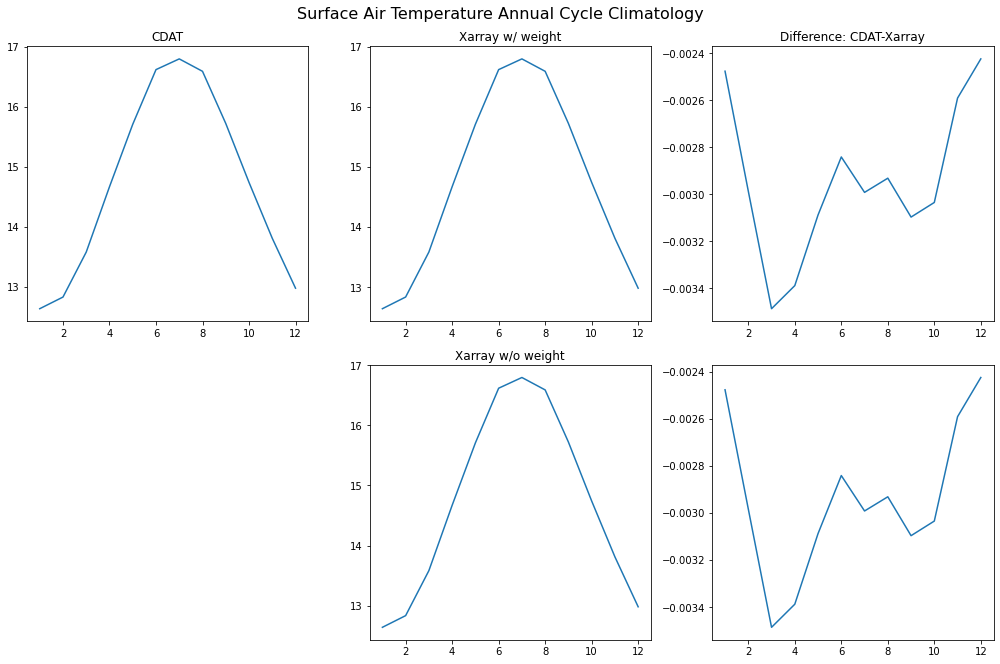

In [20]:
tstep = 1

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,9))

x = list(range(1,13))

for i in range(2):
       
    cmap = 'Spectral_r'
    vmin = -30
    vmax = 30

    cmap_diff = 'RdBu_r'
    vmin_diff = -0.1
    vmax_diff = 0.1
        
    # CDAT
    if i == 0:
        y = dc_ann_clim_ts.tolist()
        axes[i,0].plot(x, y)
    else:
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        axes[i,0].spines['bottom'].set_color('white')
        axes[i,0].spines['top'].set_color('white')
        axes[i,0].spines['left'].set_color('white')
        axes[i,0].spines['right'].set_color('white')
    
    # Xarray
    if i == 0:
        dx_tmp = dx_ann_clim_ts.values.tolist()
    elif i == 1:
        dx_tmp = dx_ann_clim_ts_no_weight.values.tolist()
    
    axes[i,1].plot(x, dx_tmp)

    # CDAT - Xarray
    y = list(dc_ann_clim_ts - dx_tmp)
    axes[i,2].plot(x, y)
    
        
for ax in axes.flat:
    ax.axes.axis('tight')
    ax.set_title('')

axes[0, 0].set_title('CDAT')
axes[0, 1].set_title('Xarray w/ weight')
axes[1, 1].set_title('Xarray w/o weight')
axes[0, 2].set_title('Difference: CDAT-Xarray')

plt.tight_layout()

fig.suptitle('Surface Air Temperature Annual Cycle Climatology', fontsize=16, y=1.02)

Difference in time series may come from difference of area average weighting.